In [1]:
#| default_exp simulation
from nbdev import *
from utilities.ipynb_docgen import *

%reload_ext autoreload
%autoreload 2

In [2]:
#| export
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

from wtlike.config import Config
from wtlike.sources import PointSource

In [3]:
#| export

class _Sampler():
    """ Sample an arbitrary function or histogram

    - func -- a function, a histogram, or a fixed value<br>
        If a function, must be positive definite.<br>
        Assume histogram bins are 0 to 1.
    - a,b  -- limits (default 0,1)
    - n    -- table size (ignored if a histogram or value)
    - rng --  a numpy.random.Generator object, or a seed
    """

    def __init__(self, func, limits=(0,1), n=100, rng=None):
        import numbers
        a,b = limits
        self.x = np.linspace(a,b,n+1) # bin edges
        dx = (b-a)/(n)/2
        self.deltafun=None
        self.rng=rng

        if callable(func):
            # A function
            # evaluate at bin centers
            y = np.array([func(t-dx) for t in self.x])
            if np.any(y<0) or np.sum(y)==0:
                raise ValueError('Function is not positive definite')

        elif isinstance(func, numbers.Number):
            # a single value, or delta function
            self.deltafun = func
            if  func<0 or func>1:
                raise ValueError('Value not in range [0,1]')
            self.mean=func
            return
        else:
            # histogram, perhaps from actual data
            y = func
            n = len(y)
            binsize = (b-a)/n
            self.x = np.arange(a+binsize/2, b, binsize)
        self.y = y
        cy = np.cumsum(y)
        # ---old mistake ---
        # d = cy[-1]-cy[0]
        # self.sy = (cy-cy[0])/d
        # self.mean = np.sum( (self.x-dx) * y) / d
        # ----------------
        self.sy = cy/cy[-1]
        self.mean = np.mean(self.sy)
        # ----------------


        
        # now do the weighted one
        wcy = np.cumsum(self.x*y)
        self.wnorm = wcy[-1]/cy[-1]
        self.wsy = wcy/wcy[-1] 
        
    def __call__(self, size, alpha=0):
        from scipy import stats
        if self.deltafun: return np.full(int(size), self.deltafun)
        size *= (1+ alpha* self.wnorm)
        return self._evaluate(stats.uniform.rvs(size=int(size), random_state=self.rng), alpha=alpha)
    
    def _evaluate(self, r, alpha=0):
        """evaluate inverse integral. expect 0<r<1 """
        
        return np.interp(r, (self.sy + alpha*self.wsy)/(1+alpha*self.wsy[-1]), self.x)

#     def _evaluate(self, r):
#         """evaluate inverse integral,  expect 0<r<1 """
#         return np.interp(r, self.sy, self.x)

#     def __call__(self, size):
#         """Generate `size` values
#         """
#         if self.deltafun: return np.full(int(size), self.deltafun)

#         return self._evaluate(stats.uniform.rvs(size=int(size), random_state=self.rng))
    
    @classmethod
    def test(cls, ):
        n = 20
        sf = cls(lambda x: np.exp(-(x**2)/2), limits=(-4, 4) )

        data = sf(10000)
        tests = np.array([np.abs(data.mean()), np.abs(data.std()-1) ])
        assert np.all(tests<5e-2 ), f'Failed Tests: mean {data.mean()}, std {data.std()}'

        func = lambda x: x**2
        wfun = cls(func)

        test2 = wfun.mean,  np.mean(wfun(1000))
        assert np.abs( test2[0]-test2[1] ) < 1e-1, f'Not almost equal: {test2}'

####   Gaussian and quadratic example functions


In [4]:
#| code-fold: show
# --- figure this out if I have to
#_Sampler.test()


### Test generating weights from a source weight histogram

Test with a function peaked at both ends, generate equal signal and background

## Simulate times and weights

In [5]:
#| export
sec_per_day = 24*3600

def generate_times(start, stop, count, rng=None):
    """ Generate a list of times, distributed randomly

    - start, stop: times
    - count : expected number to generate with rate=count/(stop-start)
    - rng : random state generator

    returns : list of times between start and stop. Note that the actual number is Poisson-distributed
    """
    # note: can speed this up by making groups of random calls

    tt =[]
    t = start
    scale = (stop-start)/count
    if rng is None: rng = np.random.default_rng()
    while True:
        t += rng.exponential(scale =scale)
        if t>stop: break
        tt.append(t)
    return tt

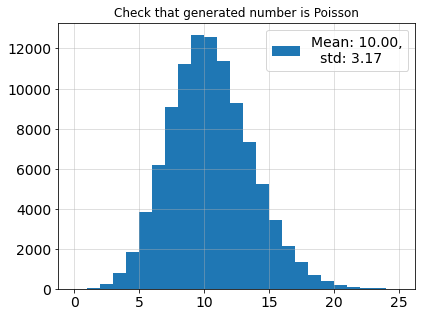

In [6]:
#| code-fold: true
rng = np.random.default_rng(42)
nn = np.array( [ len(generate_times(0,1,10, rng=rng )) for i in range(100000) ])
plt.hist(nn, np.linspace(0,25,26), label=f'Mean: {nn.mean():.2f},\n  std: {nn.std():.2f}');
plt.legend()
plt.title(f'Check that generated number is Poisson', fontsize=12);

In [7]:
#| export
class WeightFunction(object):

    def __init__(self, s=1, b=1, wt_signif=0.1, rng=None):
        self.s = s
        self.b = b
        self.lam = wt_signif
        self.rng = rng

    def psf(self, rsq, sig=0.2, gamma=2):
        """ The PSF as a function of a radius**2
        """
        #return 1/(2*np.pi* sig**2) * (1-1/gamma) * (1 + rsq/sig**2/(2*gamma))**-gamma
        return np.exp(-rsq/self.lam)/(self.lam*(1-np.exp(-1/self.lam)))

    def __call__(self, rsq):
        """ The rsq distribution function
        """
        return self.s * self.psf(rsq) + self.b

    def sample(self, s, n):
        self.s = s
        return _Sampler(self, rng=self.rng)(n);

    def weights(self, s, n):
        h = self.sample(s,  n)
        p = self.s * self.psf(h) + 1e-6 # protect against zero
        return 1/(1+self.b/p)

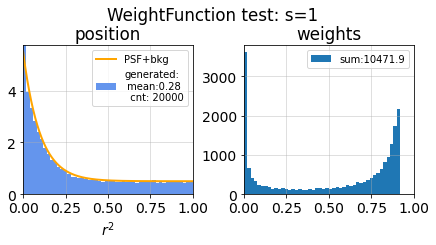

In [8]:
#| code-fold: true
# test weight function
s, lam = 1,0.1

def wfuntest(s, b=1, lam=0.1, Nb=10000, rng=42):
   
    wfun = WeightFunction(s=s,b=b,wt_signif=lam, rng=rng)
    n = int(Nb*(1+s/b)) 
    samp = wfun.sample(s, n ) 
    wts = wfun.weights(s, n)
    sumwts = np.sum(wts) #wfun.weights(s,b, 10000)

    fig, (ax1, ax3) = plt.subplots(1,2, figsize=(7,3), sharex=True)
    plt.subplots_adjust(top=0.80, wspace=0.3)
    
    r = np.linspace(0,1, 1000)  
    ax1.plot(r, wfun(r)/(s+b), '-',color='orange', lw=2,label='PSF+bkg')
    ax1.set(ylim=(0,None), xlim=(0,1), xlabel='$r^2$', title='position')
    
    ax1.hist(samp, np.linspace(0,1,51), density=True, color='cornflowerblue',
             label=f'generated:\n mean:{np.mean(samp):.2f}\n  cnt: {len(samp)}');
    ax1.legend(fontsize=10)
    #ax1.set(title='sampled', xlabel='$r^2$'); ax1.legend()
    
    
    ax3.hist(wts, bins=np.linspace(0,1,51), label=f'sum:{sumwts:.1f}')
    ax3.set(title='weights', label='weight'); ax3.legend(fontsize=10)
    fig.suptitle(f'WeightFunction test: s={s}')
wfuntest(s)

In [9]:
#| export
def make_exposure(fexp, start, stop, interval=300, costh=0.8):
    """
    - fexp -- exposure in cm^2, a value or a function of time in day units
    - start, stop -- range of time in day units
    - cos_theta -- just set to costh
    - interval [300] -- 5-min interval (fermi data is 30 s)

    Returns: a DataFrame with start, stop, exp
    """
    def check_scalar( f):
        if np.isscalar(f):
            fval = f
            return lambda t: fval
        return f
    fexp = check_scalar(fexp)

    nbins = int((stop-start)*sec_per_day / interval)
    edges = np.linspace(start, start+nbins*interval/sec_per_day, nbins+1)
    starts, stops = edges[:-1], edges[1:]
    exp = fexp(starts) * interval
    return pd.DataFrame.from_dict(dict(start=starts, stop=stops,
                                      cos_theta=np.full(nbins, costh, np.float32),
                                       exp=exp,
                                      ))

In [10]:
#| include: false
exp  = make_exposure(3000, 0, 1 )
days  = np.sum(exp.stop-exp.start); secs = days*24*3600
exptot=np.sum(exp.exp)
exp_text = f' average {exptot/secs:.0f} cm^2 for {secs/1e6:.1f} Ms'
print(exp_text)
exp.head()

 average 3000 cm^2 for 0.1 Ms


,start,stop,cos_theta,exp
0,0.000000,0.003472,0.8,900000
1,0.003472,0.006944,0.8,900000
2,0.006944,0.010417,0.8,900000
3,0.010417,0.013889,0.8,900000
4,0.013889,0.017361,0.8,900000


In [11]:
#| export
class Simulation(object):
    """
    - src_flux : source flux, scalar or function of days, typically around 1e-7
    - tstart, tstop :(days)
    - bkg_rate : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
    - efun : scalar | function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

    - wt_signif : the width of the PSF in (r/rmax)**2 coordinates
    - rng : random generator instance, or integer seed

    """

    def __init__(self, name, src_flux, tstart, tstop,
                 bkg_rate=1e-6,  efun=3000, wt_signif=5e-3,
                 debug=False, rng=None, config=None):

        def check_scalar( f):
            if np.isscalar(f):
                fval = f
                return lambda t: fval
            return f
        self.config = config or Config()
        self.source_name = name
        self.src_fun = check_scalar(src_flux)
        self.bkg_fun = check_scalar(bkg_rate)
        self.flux_fun = lambda t: src_fun(t)+bkg_fun(t)
        self.wt_signif=wt_signif

        self.exposure = make_exposure(efun, tstart, tstop)
        if isinstance(rng, np.random.Generator):
            self.rng = rng
        else:
            self.rng = np.random.default_rng(rng)
        self.filename = None #flag that not a regular source
        self.debug=debug


    def run(self):
        times = []
        weights = []
        for start, stop, costh, exp  in self.exposure.itertuples(index=False,name=None):

            src = self.src_fun((start+stop)/2)
            bkg = self.bkg_fun((start+stop)/2)
            delta_t = (stop-start)*sec_per_day # tolal tim
            counts = (src+bkg) * exp
            new_times = generate_times(start, stop, counts, rng=self.rng)
            wfun = WeightFunction(wt_signif=self.wt_signif, s=src, b=bkg, rng=self.rng)
            new_wts = wfun.weights(s=src, n=len(new_times))
            if self.debug>0:
                print(f'time: {start:.3f} - {stop:.3f}, source {src}, exposure/s {exp/delta_t:.0f}, expected/generated counts {counts:.0f}/{len(new_wts)}')
            if self.debug>0:
                print(f'\t weights {np.array(new_wts).round(2)}')
                self.debug-=1

            assert len(new_times)==len(new_wts)
            times = np.append(times, new_times)
            weights = np.append(weights, new_wts)

        print(f'generated {len(times)} photons')
        self.photons=pd.DataFrame(dict(
            time=times,
            weight=weights.astype(np.float32),
        ))

time: 0.000 - 0.003, source 1e-06, exposure/s 3000, expected/generated counts 2/0
	 weights []
time: 0.003 - 0.007, source 1e-06, exposure/s 3000, expected/generated counts 2/0
	 weights []
time: 0.007 - 0.010, source 1e-06, exposure/s 3000, expected/generated counts 2/0
	 weights []
time: 0.010 - 0.014, source 1e-06, exposure/s 3000, expected/generated counts 2/2
	 weights [0.99 0.99]
time: 0.014 - 0.017, source 1e-06, exposure/s 3000, expected/generated counts 2/3
	 weights [1.   0.98 1.  ]
time: 0.017 - 0.021, source 1e-06, exposure/s 3000, expected/generated counts 2/4
	 weights [0.99 1.   0.5  0.5 ]
time: 0.021 - 0.024, source 1e-06, exposure/s 3000, expected/generated counts 2/5
	 weights [1.  0.5 1.  1.  1. ]
time: 0.024 - 0.028, source 1e-06, exposure/s 3000, expected/generated counts 2/3
	 weights [1.   1.   0.97]
time: 0.028 - 0.031, source 1e-06, exposure/s 3000, expected/generated counts 2/2
	 weights [0.98 1.  ]
time: 0.031 - 0.035, source 1e-06, exposure/s 3000, expected/

,start,stop,cos_theta,exp
count,2880.000000,2880.000000,2880.000000,2880.0
mean,4.998264,5.001736,0.800000,900000.0
std,2.887252,2.887252,0.000023,0.0
min,0.000000,0.003472,0.800000,900000.0
25%,2.499132,2.502604,0.800000,900000.0
50%,4.998264,5.001736,0.800000,900000.0
75%,7.497396,7.500868,0.800000,900000.0
max,9.996528,10.000000,0.800000,900000.0


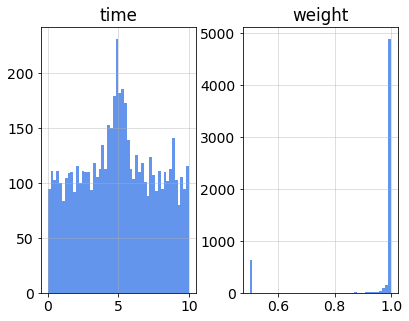

In [12]:
#| code-fold: true
def src_flare(t, tzero=5, width=0.25, amp=2):
    return 1e-6*(1 + amp*np.exp(-(t-tzero)**2/2/width))
sim = Simulation('test_sim', src_flux=src_flare, tstart=0, tstop=10, rng=42 , debug=10)
sim.run()
sim.photons.hist(bins=50, color='cornflowerblue');
sim.exposure.describe()

In [13]:
show_doc(Simulation)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/simulation.py#L190){target="_blank" style="float:right; font-size:smaller"}

### Simulation

>      Simulation (name, src_flux, tstart, tstop, bkg_rate=1e-06, efun=3000,
>                  wt_signif=0.005, debug=False, rng=None, config=None)

- src_flux : source flux, scalar or function of days, typically around 1e-7
- tstart, tstop :(days)
- bkg_rate : background flux, scalar or function of day, typicaly 1e-6 for 4-deg cone
- efun : scalar | function (of time in days) of the exposure/s. Typically 3000 cm^2 for fermi

- wt_signif : the width of the PSF in (r/rmax)**2 coordinates
- rng : random generator instance, or integer seed

In [14]:
#| export
class WtGen(dict):
    """
    Encapsulate the dict of weights used by wtlike for simulation

    It is a functor of a list of uniform probabilities, which retuns a DataFrame with
    columns bandid, weight, pixel index

    """

    def __init__(self, src, aeff=lambda bandid :1 ):
        """
        - src : A PointSource object
        - aeff default unity : function(bandid) of the relative effective area

        """
        self.update(src.wtman.wt_dict)
        self.src= src # keep ref to the source
        self.aeff = aeff
        self.setup()

    def setup(self, alpha=None):

        # the seletion weight to apply to a pixel, depending only on the band
        s = np.empty(0, np.float32)

        # the bandid, weight and pixel index,normalized to 1024, for each pixel
        b = np.empty(0, np.uint8)
        w = np.empty(0, np.float32)
        p = np.empty(0, np.uint32)

        for key, value in self.items():
            nside = value['nside']
            pixel_ratio = (1024//nside)**2
            wts = value['wts'].astype(np.float32)
            wsum = wts.sum()
            n = len(wts)

            # construct the weighting array for this band
            c = value['flux']/wsum * self.aeff(key) # the constant part
            if alpha is None:
                t = np.full(n, c, np.float32)
            else: # instead somthing tahta adusts the weight if alpkha is not zeero
                t = c * (1 + alpha(key) * wts)
            s = np.append(s, t)

            # now the event list
            b = np.append(b, np.full(n, key, np.uint8))
            w = np.append(w, wts)
            p = np.append(p, value['pixels']*pixel_ratio)
        self.df = pd.DataFrame( dict(bandid=b, weight=w, pixel=p) )
        cums = np.cumsum(s)
        self.cums = cums/cums[-1]

    def __str__(self):
        return f'WtGen for {self.src}'
    def __repr__(self):
        return str(self)

    @property
    def energies(self):
        " List of energies for bandid//2 "
        t = self.src.wtman['energy_bins']
        return 0.5*(t[1:] + t[:-1])

    def __call__(self, generated, alpha=None):
        """ Create an event DataFrame

        - generated : list of values uniformly distributed in (0,1)
        - alpha default None, a function of bandid
        """
        if alpha is not None: self.setup(alpha)
        genidx =  np.searchsorted(self.cums, generated)
        return self.df.iloc[genidx]

In [15]:
show_doc(WtGen)

---

[source](https://github.com/tburnett/wtlike/tree/master/blob/master/wtlike/simulation.py#L256){target="_blank" style="float:right; font-size:smaller"}

### WtGen

>      WtGen (src, aeff=<function <lambda>>)

Encapsulate the dict of weights used by wtlike for simulation

It is a functor of a list of uniform probabilities, which retuns a DataFrame with
columns bandid, weight, pixel index

### Test by generating with Geminga 

Check SED as measued with sums of weights for each band with input SED

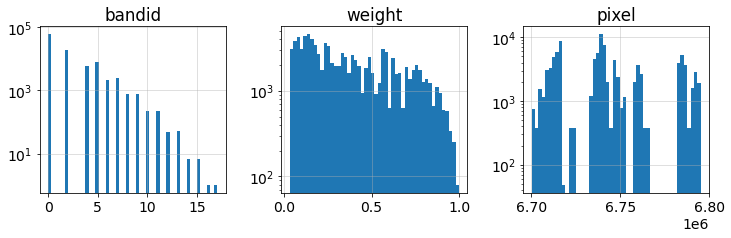

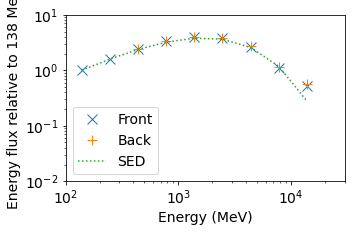

In [16]:
#| echo: false
from wtlike.sources import PointSource
src_name = 'Geminga'
src  = PointSource('Geminga')
self = WtGen(src)

generated = np.linspace(0, 1, int(1e5))
df = self(generated, alpha=lambda k: 0.1)

df.hist( log=True, bins=50, layout=(1,3), figsize=(12,3));
# plt.gcf().suptitle(f' {len(df)} Generated events')

pt = df.pivot_table(index='bandid', values='weight', aggfunc=['count','sum']); 

ee = self.energies[pt.index//2]
even = pt.index%2==0
ee0 = ee[even]
fig, ax = plt.subplots(figsize=(5,3))
norm = pt.loc[0, ('sum','weight')]*ee[0]**2
ax.set(xlim=(100,3e4),  ylim=(0.01, 10), xticks=[1e2,1e3,1e4], xticklabels='100 1000 $10^4$'.split(),
      xlabel='Energy (MeV)', ylabel='Energy flux relative to 138 MeV')
ax.loglog(ee0, pt[even].loc[:,('sum','weight')]*ee0**2/norm, 'x', ms=10, label='Front')
ee1 = ee[~even]
ax.loglog(ee1, pt[~even].loc[:,('sum','weight')]*ee1**2/norm, '+', ms=10, label='Back')

flux10 = np.array([value['flux'] for value in self.values()]) *1e10
y = flux10*ee**2
ax.loglog(ee, y/y[0], ':', label='SED');
ax.legend(); ax.grid();

In [17]:
%time self.setup()#alpha = lambda n: 0)

CPU times: user 1.97 ms, sys: 0 ns, total: 1.97 ms
Wall time: 1.74 ms


In [18]:
#| include: false
from nbdev import nbdev_export
nbdev_export()
!date

Sat Jul  8 04:46:48 PDT 2023
